## Step 0: Initialize and set dependencies

In [32]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
import pickle

In [33]:
# Read data
df = pd.read_csv('../data/data.csv')

## Step 1: Preprocess and scale data

In [34]:
# Select valid observations
df = df[(df['nwave'] == 3) & (df['longipart'] == 123)]

In [35]:
# Create a new column with a repeating sequence of 1, 2, 3
df['time_wave'] = [(i % 3) + 1 for i in range(len(df))]

In [36]:
changes_in_sex_column = {
    2115: 1,
    2669: 1,
    3643: 1,
    5185: 2,
    5384: 2,
    2184: 1
}
# Update 'sex' column based on 'id'
df['sex'] = df['id'].map(changes_in_sex_column).fillna(df['sex'])

In [37]:
# Check missing vaulues
missing_values = df.isnull().sum()
print(missing_values/len(df))

id           0.000000
nwave        0.000000
longipart    0.000000
age          0.001042
sex          0.000000
year         0.000000
bmi          0.001042
physact      0.000000
health       0.000000
psyt         0.000000
cop_e        0.000000
cop_p        0.000000
cop_h        0.000000
fmale        0.000000
part         0.000000
socsup       0.000000
educ_par     0.000000
jobhours     0.000000
cesd         0.000000
bdi_su       0.000000
stai         0.000000
stress       0.000000
mbi_ex       0.000000
mbi_cy       0.000000
mbi_ea       0.000000
time_wave    0.000000
dtype: float64


In [38]:
# Delete missing values listwise
df = df.dropna()

In [39]:
# Sort the data by 'time_wave'
df_sorted = df.sort_values('time_wave')

In [40]:
# Store 'cesd' in 2D array and scale it
X = df_sorted['cesd'].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
X_scaled.shape

(958, 1)

In [42]:
# Store lengths of each time wave
lengths = df_sorted['time_wave'].value_counts().sort_index().values

In [43]:
lengths

array([319, 320, 319], dtype=int64)

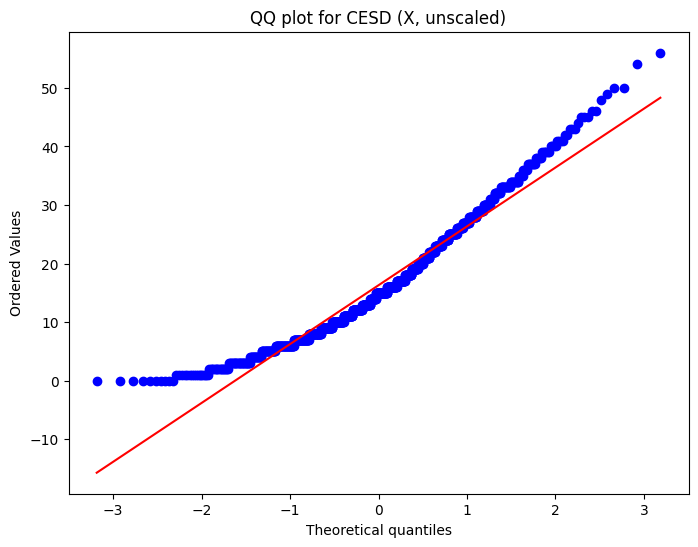

In [44]:
# Check for normality
plt.figure(figsize=(8, 6))
stats.probplot(df_sorted['cesd'], dist="norm", plot=plt)
plt.title("QQ plot for CESD (X, unscaled)")
plt.show()

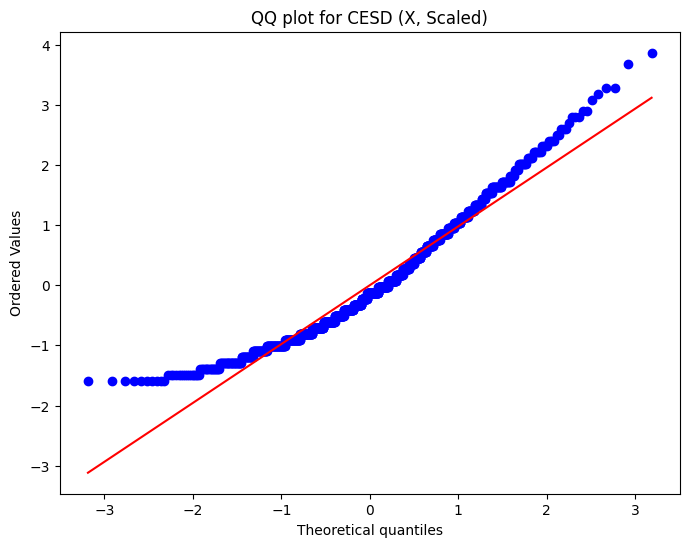

In [45]:
plt.figure(figsize=(8, 6))
stats.probplot(X_scaled.flatten(), dist="norm", plot=plt)
plt.title("QQ plot for CESD (X, Scaled)")
plt.show()


## Step 3: Train the model

Next, we perform a hyperparameter search to fit a Gaussian Hidden Markov Model (HMM) to the scaled data X_scaled. We test different number of hidden states (n_states between 2 and 10). For each combination, the model is initialized multiple times (10 times), each with a different random seed. For each model, it computes the log-likelihood, AIC, and BIC, and keeps track of the best model based on the lowest AIC and BIC criteria. The results, including the best model for each configuration, are stored in the results list.

In [30]:
results = []
all_results = [] 

n_initializations = 10
covariance_type = "spherical" # we do not need to test different covariance types as we have only one feature (X_scaled)
best_aic = np.inf
best_bic = np.inf
best_model = None
best_log_likelihood = None

In [46]:
# Initialize list to store results
all_results = []
results = []

# Initialize tracking for OVERALL best model
overall_best_aic = np.inf
overall_best_model = None
overall_best_n_states = None

for n_states in range(2,10):
    # Initialize best tracking for THIS number of states
    best_aic_for_state = np.inf
    best_bic_for_state = np.inf
    best_model_for_state = None
    best_ll_for_state = None
    
    initialization_results = []
    
    # Test multiple initializations for this number of states
    for init in range(n_initializations):
        random_state = 1300 + init
        model = hmm.GaussianHMM(
            n_components=n_states,
            covariance_type=covariance_type,
            n_iter=600,
            random_state=random_state,
            verbose=True,
        )

        model.fit(X_scaled, lengths=lengths)
        log_likelihood = model.score(X_scaled, lengths=lengths)
        aic = model.aic(X_scaled, lengths=lengths)
        bic = model.bic(X_scaled, lengths=lengths)
        
        initialization_results.append({
            'n_states': n_states,
            'initialization': init,
            'log_likelihood': log_likelihood,
            'aic': aic,
            'bic': bic,
            'model_params': {
                'means': model.means_.copy(),
                'covars': model.covars_.copy(),
                'transmat': model.transmat_.copy(),
                'startprob': model.startprob_.copy()
            }
        })

        # Update best model for this number of states
        if aic < best_aic_for_state:
            best_aic_for_state = aic
            best_bic_for_state = bic
            best_model_for_state = model
            best_ll_for_state = log_likelihood

    # Store all initialization results
    all_results.extend(initialization_results)
    
    # Store the best result for this number of states
    results.append({
        'n_states': n_states,
        'log_likelihood': best_ll_for_state,
        'aic': best_aic_for_state,
        'bic': best_bic_for_state,
        'model': best_model_for_state
    })

    # Update overall best model if this n_states gave us better AIC
    if best_aic_for_state < overall_best_aic:
        overall_best_aic = best_aic_for_state
        overall_best_model = best_model_for_state
        overall_best_n_states = n_states


         1   -1407.06926318             +nan
         2   -1332.00649468     +75.06276850
         3   -1329.75746547      +2.24902921
         4   -1327.90035729      +1.85710818
         5   -1325.43422814      +2.46612915
         6   -1322.26212747      +3.17210067
         7   -1318.42855507      +3.83357240
         8   -1314.15539089      +4.27316418
         9   -1309.88309509      +4.27229580
        10   -1306.10821051      +3.77488458
        11   -1303.13056780      +2.97764271
        12   -1300.96019619      +2.17037161
        13   -1299.41355910      +1.54663709
        14   -1298.26703334      +1.14652576
        15   -1297.35000085      +0.91703249
        16   -1296.56058202      +0.78941883
        17   -1295.84598380      +0.71459822
        18   -1295.18073901      +0.66524479
        19   -1294.55277326      +0.62796576
        20   -1293.95619515      +0.59657811
        21   -1293.38791995      +0.56827520
        22   -1292.84615089      +0.54176906
        23

In [117]:
overall_best_model

GaussianHMM(covariance_type='spherical', n_components=4, n_iter=600,
            random_state=1307, verbose=True)

In [118]:
overall_best_model.monitor_.report

<bound method ConvergenceMonitor.report of ConvergenceMonitor(
    history=[-1784.377481301869, -1303.1576175173432, -1297.7033198018635, -1295.226279791397, -1293.5135455159777, -1292.2601959353692, -1291.298067782258, -1290.5101349562403, -1289.8211917390959, -1289.1871500953714, -1288.5839935359436, -1287.999392995514, -1287.4275031219404, -1286.8661770177678, -1286.3156218727684, -1285.7777092703973, -1285.2554260059053, -1284.7522271099435, -1284.2713055522008, -1283.8149556521707, -1283.3842160393797, -1282.9788571075865, -1282.597634451622, -1282.2386589016269, -1281.8997505074103, -1281.5787038682581, -1281.2734486344957, -1280.9821215162294, -1280.7030765645927, -1280.434858365589, -1280.1761562205716, -1279.9257507815873, -1279.6824595395829, -1279.4450841632129, -1279.2123605892118, -1278.9829115629068, -1278.7552007604986, -1278.527487677331, -1278.2977834796097, -1278.0638108703945, -1277.8229773275411, -1277.572383090399, -1277.3089046882046, -1277.0294187931281, -1276.73

In [116]:
print(f"Overall best model: {overall_best_model}")
print(f"Overall best number of states: {overall_best_n_states}")
print(f"Overall best log likelihood: {overall_best_model.monitor_.history[-1]}")
print(f"Overall best AIC: {overall_best_aic}")
print(f"Overall best BIC: {overall_best_model.bic(X_scaled, lengths=lengths)}")


Overall best model: GaussianHMM(covariance_type='spherical', n_components=4, n_iter=600,
            random_state=1307, verbose=True)
Overall best number of states: 4
Overall best log likelihood: -1261.4345291370114
Overall best AIC: 2568.85154139606
Overall best BIC: 2680.7430402893897


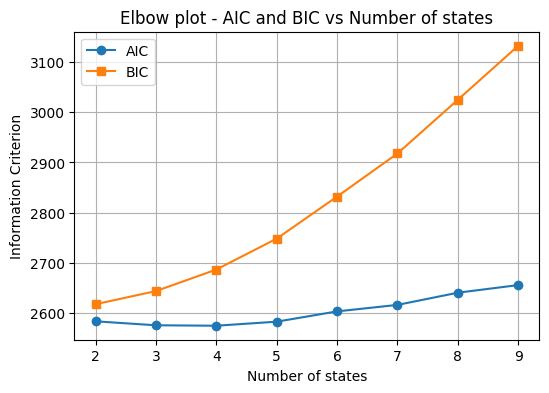

In [103]:
# Visualize AIC/BIC vs number of states

all_results_df = pd.DataFrame(all_results)
plt.figure(figsize=(6, 4))
plt.plot(all_results_df.groupby('n_states')['aic'].mean(), 'o-', label='AIC')
plt.plot(all_results_df.groupby('n_states')['bic'].mean(), 's-', label='BIC')
plt.xlabel('Number of states')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('Elbow plot - AIC and BIC vs Number of states')
plt.grid(True)
plt.show()


## Step 4: Predict

In [104]:
# Decode: Find most likely state  corresponding to X_scaled
log_prob, state = overall_best_model.decode(X_scaled, lengths=lengths) # default algorithm is viterbi

In [105]:
print(f"Log probability: {log_prob}")
print(f"State sequence: {state.shape}")

Log probability: -1499.4054954775766
State sequence: (958,)


In [106]:
df_sorted['states'] = state
df_sorted['states'].value_counts()

states
2    364
3    309
0    225
1     60
Name: count, dtype: int64

In [107]:
df_predictions = pd.DataFrame({
    'X_scaled': X_scaled.flatten(),  # Flatten to a 1D array (if needed)
    'predicted_states': state
})

In [ ]:
# Round the transition matrix to 2 decimal places
np.round(overall_best_model.transmat_, 2)

array([[0.43, 0.09, 0.29, 0.19],
       [0.31, 0.07, 0.45, 0.17],
       [0.2 , 0.04, 0.49, 0.28],
       [0.07, 0.05, 0.48, 0.4 ]])

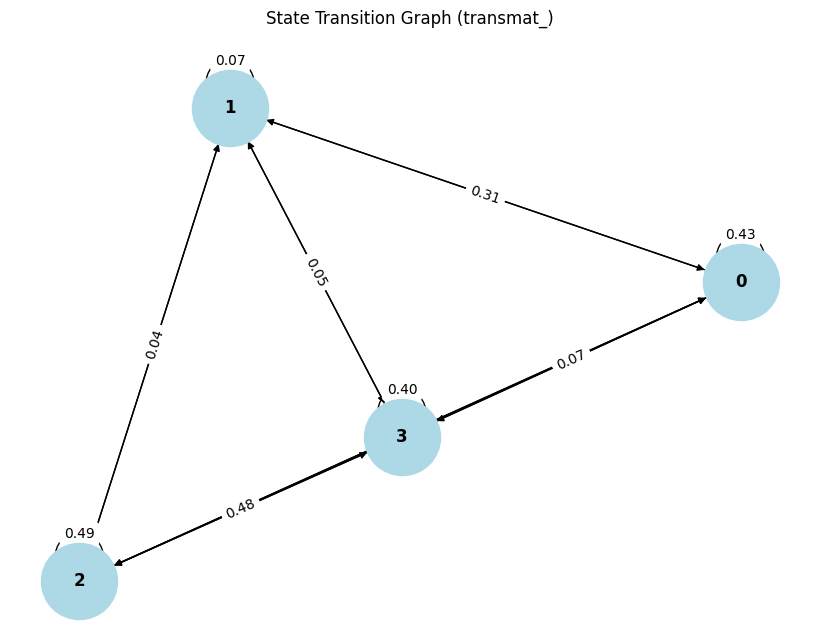

In [114]:
# Plot transition matrix as a graph
transmat = overall_best_model.transmat_

G = nx.DiGraph()
n_states = overall_best_model.n_components

for i in range(n_states):
    G.add_node(i)

for i in range(n_states):
    for j in range(n_states):
        if transmat[i, j] > 0:  # Only add edges for non-zero probabilities
            G.add_edge(i, j, weight=transmat[i, j])

# Positioning of nodes
pos = nx.spring_layout(G, seed=142)  # Positioning of nodes

# Draw 
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=12, font_weight="bold", arrows=True)

# Add labels to edges with transition probabilities
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{weight:.2f}' for (i, j), weight in edge_labels.items()})

# Add title
plt.title('State Transition Graph (transmat_)')
plt.show()


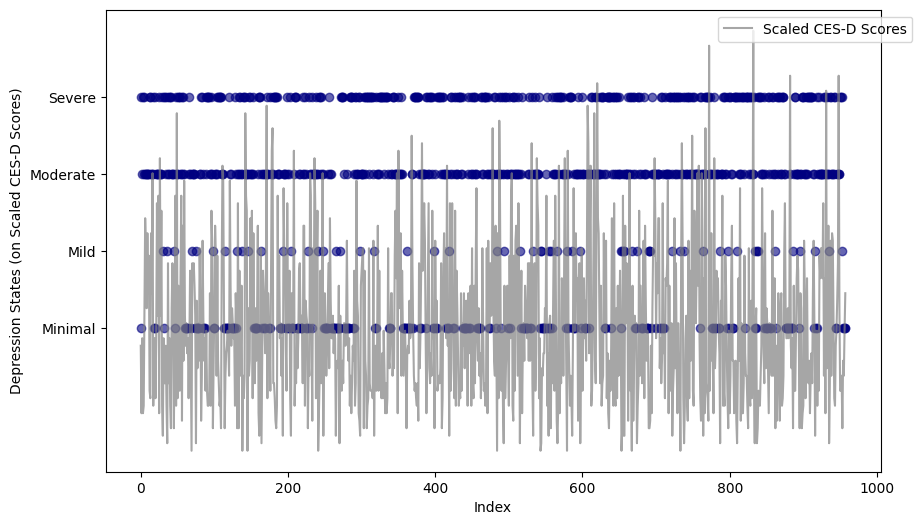

In [152]:
# Plot state predictions

plt.figure(figsize=(10, 6))

# Plot the scaled scores
plt.plot(df_predictions['X_scaled'], label='Scaled CES-D Scores', color='grey', alpha=0.7)

# Create custom scatter plots for each state with appropriate labels
state_labels = ['Minimal', 'Mild', 'Moderate', 'Severe']

for state in range(4):
    mask = df_predictions['predicted_states'] == state
    plt.scatter(np.arange(len(df_predictions))[mask], 
                df_predictions['predicted_states'][mask], # mask here is the state number (0, 1, 2, 3)
                color='navy',
                alpha=0.6)

# plt.title('Gaussian HMM State Predictions (n = 4)')
plt.xlabel('Index')
plt.ylabel('Depression States (on Scaled CES-D Scores)')
plt.yticks(range(4), state_labels)  # Replace numeric y-axis with state labels
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
# plt.tight_layout()
plt.show()

## Step 5: Save the model

In [86]:
# Save the model
with open('best_gaussian_hmm_model.pkl', 'wb') as f:
    pickle.dump(overall_best_model, f)